In [1]:
import gc,sys
import pdb

#pdb.set_trace()
from tqdm import tqdm

import os, mlflow, mlflow.pytorch
import __init__

from transformation.gp_cpab import gp_cpab
from transformation.configManager import configManager
from extra.utilities import *
from extra.dataLoaderDiffeo import *
from extra.LossFunctionsAlternatives import LossFunctionsAlternatives
from extra.Automatic_Report import Generate_Automatic_Report
from transformation.libcpab.libcpab.pytorch.interpolation import interpolate1D

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [2]:
import pandas as pd
from extra.logomakers import logomaker_plots 

def plot_logos_probs(x1_trans, alphabets, pathfolder, path):  
    #from logomakers import logomaker_plots  

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabets] 
    x1_trans_logo_input = df_construction_aas([ x1_trans.detach().numpy() ]*500, x1_trans.shape, alphabets_logo)
    best = logomaker_plots.plotlogos(x1_trans_logo_input[x1_trans_logo_input.columns.tolist()],pathfolder,'transformed_'+path)

    return best

In [3]:
def training_theta_optima(path_preexist_model, theta_est, maxiter, optimizer, T,x1, ref_msa, modeflag, msa_num, loss_vals, loss_function, inverse):

 
    if os.path.isfile(path_preexist_model):
        print ("Loading Deformation Model")
        theta_est = torch.load(path_preexist_model)
    else:
        pb = tqdm(desc='Alignment of samples', unit='iters', total=maxiter)
        for i in range(maxiter):
            optimizer.zero_grad()
            #pdb.set_trace()

            if inverse == True:
                opt_est = -theta_est

            if T.interpolation_type == 'linear':
                x1_trans, _,  forw_per = T.spatial_transformation(x1, ref_msa, opt_est, modeflag)

                loss = loss_function(method = 'Soft_Label_KLD', input = x1_trans, target = ref_msa, forw_per=forw_per)

            else:
                #pdb.set_trace()
                x1_trans, sampled_data, forw_per = T.spatial_transformation(x1, ref_msa, opt_est, modeflag)

                loss = loss_function(method = 'Soft_Label_KLD', input = x1_trans, target = ref_msa, forw_per=forw_per)


            loss_vals.append(loss.item())
            loss.backward()
            optimizer.step()


            gc.collect()
            torch.cuda.empty_cache()
            #torch.save(theta_est, path_preexist_model)



            pb.update()
            pb.set_postfix({'loss': str(loss.item())})

            msa_num.append(x1_trans.detach().numpy().squeeze())


        pb.close()
        shapes = ref_msa.squeeze().shape
        msa_num = np.vstack(msa_num).reshape(-1, shapes[0], shapes[1])


    return theta_est

def get_interpolated_data(data, T, outsize):
    data1=data.unsqueeze(0)
    grid = T.uniform_meshgrid(outsize).repeat(data1.shape[0],1,1)
    out = interpolate1D(data1,grid,outsize)
    return out.squeeze(0)


In [25]:
print(__package__)
'''---------------------------------------------------------'''
std = configManager("../../configs/setup2.yaml")
device = std.parserinfo('*/Device')
modeflag = std.parserinfo('*/Modeflag')
window_grid = std.parserinfo('*/Window_grid')
channels = std.parserinfo('*/Channels')
option = std.parserinfo('*/Option')


path = std.parserinfo('*/PathOrig')
path_MSA_test = std.parserinfo('*/PathMSAref9')#PathMSAref4t
path_preexist_model = std.parserinfo('*/Path_Preexist_Modellinear')
path_preexist_modelGP = std.parserinfo('*/Path_Preexist_ModelGP')

pathX123 = std.parserinfo('*/Path_Automated_ReportFolder')
indexlogolinear = '_LI_3aa9g_padd'
indexlogoGP = '_GP_3aa9g_padd'
indexoutputT = 'debugging_cpab_domains.txt' #'results_3aa_Inverse_direct.txt'

# Reference Information - how the alignment should looks like
alignment, ref_msa, alphabets, c2i, i2c, i2i,seqchar = read_clustal_align_output(path_MSA_test)


'''---------------------------------------------------------'''
'''---------------------------------------------------------'''
'''---------------------------------------------------------'''
# Raw Sequences, to see if we can align the sequences somehow
dataset_msa = datasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True)

x1 = dataset_msa.prot_space
#ref_msa = torch.cat((ref_msa,torch.tensor([0.33]*3).reshape(1,1,3) ), 1 )

padding_enable = 'padding_weights'

if padding_enable != 'padding_weights':
  padd_replication = 0 
else:
  padd_replication = ref_msa.shape[1] - x1.shape[1]

if padd_replication!=0:
    padd = torch.ones(1,padd_replication,4)*0.33; x1 = torch.cat(( x1 ,padd),1)
else:
    padd = torch.tensor([])

# reconvert the dimensions of reference and input datasets
if modeflag == '2D':
  # convert into [#channels, #width, #height, #channels]
  x1 = x1.reshape(x1.shape[0], x1.shape[1], 1, x1.shape[2])
  ref_msa = ref_msa.reshape(ref_msa.shape[0], ref_msa.shape[1], 1, ref_msa.shape[2])
  ndim = [window_grid,1]
else:
  ndim = [window_grid]

'''Transformations for Reference Alignment'''
'''-----------------------------------------------------------------------------------------------'''
'''      JUST FOR CAPTURING DEFORMATION PATTERNS ALONG THE CPAB, HOW IT STARS AND IT ENDS:        '''
'''-----------------------------------------------------------------------------------------------'''
''' NEEDS TO BE IN ZERO_BOUNDARY IN FALSE FOR GETTING PROPER RESULTS IN ALIGNMENTS'''
T = gp_cpab(ndim, std, backend='pytorch', device=device, zero_boundary=False,
                                          volume_perservation=False, override=False)

T.interpolation_type = 'linear'


x1 = T.backend.to(x1.clone().detach(), device=device)
ref_msa = T.backend.to(ref_msa.clone().detach(), device=device)


''' LIKELIHOOD DEFINITIONS:'''

if option == 'multitask':
    #T.get_interpolation_inductive_points(x1, x1.float()) 
    
    outsize = (ref_msa.shape[1], ref_msa.shape[2])
    padded_idx = [*range(x1.shape[1],ref_msa.shape[1])]
    non_padded_idx = set(range(0, outsize[0])) - set(padded_idx) 
    non_padded_idx = [*non_padded_idx]

    ''' TEMP SOLUTION FOR THE EXPERIMENT WITH THE MODIFICATIONS'''
    '''---------------------------------------------------------------------------'''
    padded_idx = non_padded_idx[(ref_msa.shape[1] - padd_replication):]; non_padded_idx =  non_padded_idx[:(ref_msa.shape[1] - padd_replication)]
    '''---------------------------------------------------------------------------'''

    padded_idx = [ padded_idx ]; non_padded_idx = [ non_padded_idx ]

    T.get_interpolation_inductive_points(x1, x1.float(), 
                                        outsize = outsize, 
                                        padded_idx = padded_idx, 
                                        non_padded_idx = non_padded_idx,
                                        #separation_size_grid = T.params.inc[0],
                                        padding_option = padding_enable   )
                                        #padding_option = 'none'   )

    

'''
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
'''

''' FOR CASES 1,2,3,4 GAPS WITH INVERSE'''

#theta_ref = torch.autograd.Variable(torch.tensor([[-0.3,0.0011522,0.0018782, 0.2456, -0.3125]], requires_grad=True), requires_grad=True)
#theta_ref  = get_interpolated_data(theta_ref, T, (T.params.nC+1,T.params.nC+1))
''' FOR CASES 10 GAPS WITH INVERSE'''
#theta_ref = torch.autograd.Variable(torch.tensor([[0.003,  -0.006, 0.003, 0.006,  -0.003]], requires_grad=True), requires_grad=True)

'''
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------

'''

theta_ref = torch.autograd.Variable(T.identity(1, epsilon=1e-6), requires_grad=True)
theta_est = torch.autograd.Variable(theta_ref.clone(), requires_grad=True)
theta_est_GP = torch.autograd.Variable(theta_ref.clone(), requires_grad=True)


'''lr=0.01 is the best one so far for linear interpolation and gp'''
lr = std.parserinfo('*/lr') 
wd = std.parserinfo('*/weight_decay')
maxiter = std.parserinfo('*/maxiter')

optimizer = torch.optim.AdamW([theta_est], lr=lr) #, weight_decay=wd)
optimizerGP = torch.optim.AdamW([theta_est_GP], lr=lr)


loss_function = LossFunctionsAlternatives()
loss_function.get_dictionaries_to_mask_data(c2i, i2c, i2i)
#pdb.set_trace()
msa_num = []; loss_vals =[]
msa_numGP = []; loss_valsgp =[]

inverse = True




T.interpolation_type = 'linear'
theta_est = training_theta_optima(path_preexist_model, theta_est, maxiter, optimizer, T,x1, ref_msa, 
                                            modeflag, msa_num, loss_vals, loss_function, inverse = inverse)

x1_trans1, _, forw_per = T.spatial_transformation(x1, ref_msa, -theta_est, modeflag)
x1_trans1_dir,_, forw_per = T.spatial_transformation(x1_trans1, ref_msa, theta_est, modeflag)
loss1 = loss_function(method = 'Soft_Label_KLD', input = x1_trans1, target = ref_msa, forw_per=forw_per)



""""
T.interpolation_type = 'GP'
theta_est_GP = training_theta_optima(path_preexist_modelGP, theta_est_GP, maxiter, optimizerGP, T, x1, ref_msa, 
                                            modeflag, msa_numGP, loss_valsgp, loss_function, inverse = inverse)

x1_trans3, sampled_data3, forw_per = T.spatial_transformation(x1, ref_msa, -theta_est_GP, modeflag)
print("reverse transformed CPAB using GP: \n\n {0}".format(x1_trans3))

#T.setup='None'
T.interpolation_type = 'linear'
x1_trans3_dir, _, forw_per = T.spatial_transformation(x1_trans3, ref_msa, theta_est_GP, modeflag)
print("direct transformed CPAB using linear with theta_GP: \n\n {0}".format(x1_trans3_dir))


loss3 = loss_function(method = 'Soft_Label_KLD', input = x1_trans3, target = ref_msa, forw_per=forw_per)

print('\n\n\n Loss Function by using GPs = '+ str(loss3) )
"""


/workspaces/Explicit_Disentanglement_Proteins/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


None
tmp


Alignment of samples: 100%|██████████| 500/500 [01:03<00:00,  7.90iters/s, loss=0.334215372800827]


'"\nT.interpolation_type = \'GP\'\ntheta_est_GP = training_theta_optima(path_preexist_modelGP, theta_est_GP, maxiter, optimizerGP, T, x1, ref_msa, \n                                            modeflag, msa_numGP, loss_valsgp, loss_function, inverse = inverse)\n\nx1_trans3, sampled_data3, forw_per = T.spatial_transformation(x1, ref_msa, -theta_est_GP, modeflag)\nprint("reverse transformed CPAB using GP: \n\n {0}".format(x1_trans3))\n\n#T.setup=\'None\'\nT.interpolation_type = \'linear\'\nx1_trans3_dir, _, forw_per = T.spatial_transformation(x1_trans3, ref_msa, theta_est_GP, modeflag)\nprint("direct transformed CPAB using linear with theta_GP: \n\n {0}".format(x1_trans3_dir))\n\n\nloss3 = loss_function(method = \'Soft_Label_KLD\', input = x1_trans3, target = ref_msa, forw_per=forw_per)\n\nprint(\'\n\n\n Loss Function by using GPs = \'+ str(loss3) )\n'

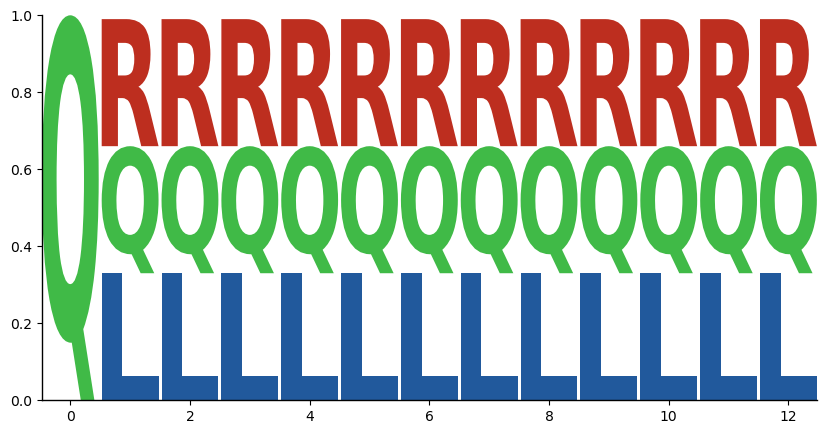

input: tensor([[[0.0000, 0.0000, 1.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300],
         [0.3300, 0.3300, 0.3300, 0.3300]]]) 

ref: tensor([[[0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.]]]) 



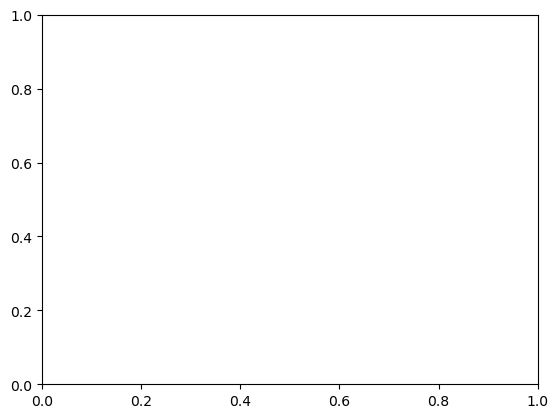

In [26]:
#plot_logos_probs(x1_trans3, alphabets, '../../Results', '_4aa_nopadd_with_init')
plot_logos_probs(x1_trans1[:,:,1:], alphabets[1:], '../../Results', '_4aa_nopadd_with_init')

#plot_logos_probs(x1_trans3[:,1:4,:], alphabets, '../../Results', '_4aa_nopadd_with_init')
print("input: {0} \n".format(x1))
print("ref: {0} \n".format(ref_msa))

#print("inverse transform: {0}".format(x1_trans3))

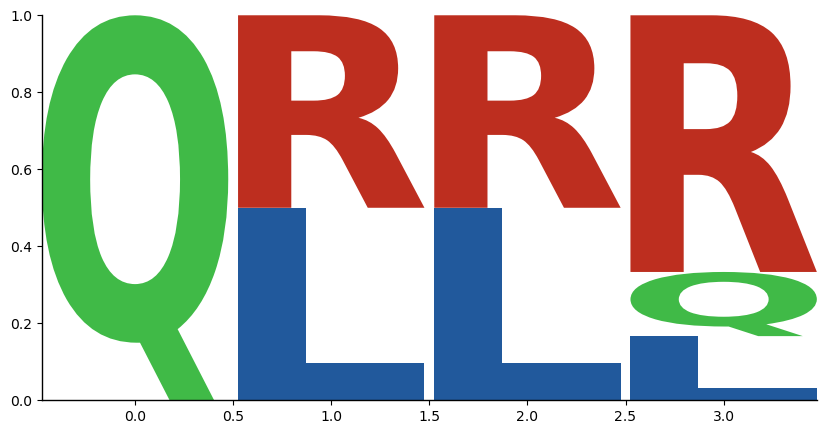

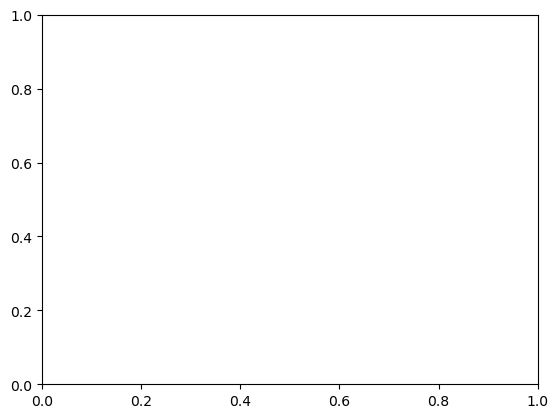

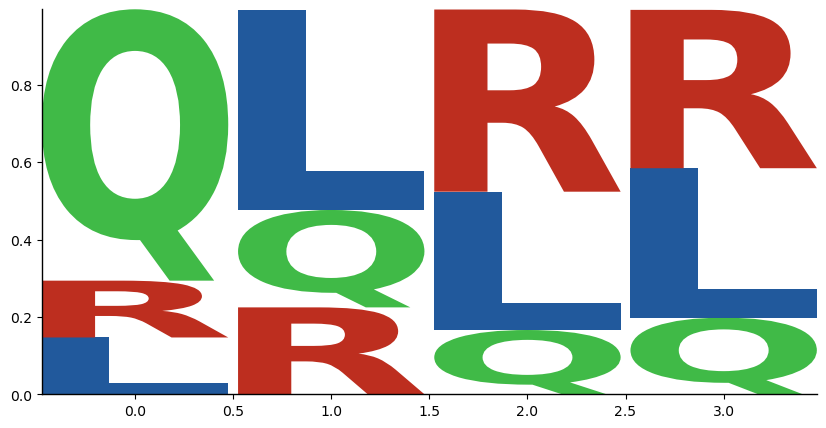

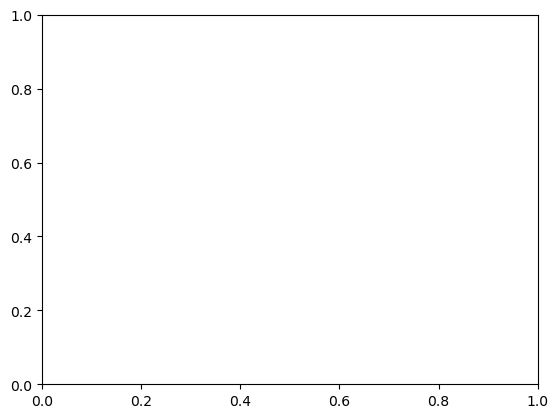

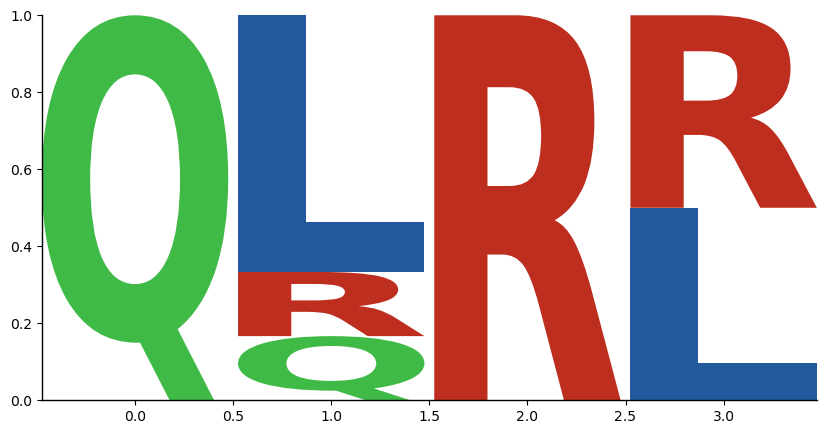

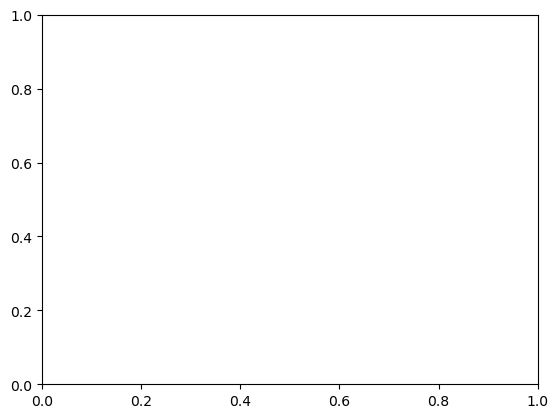

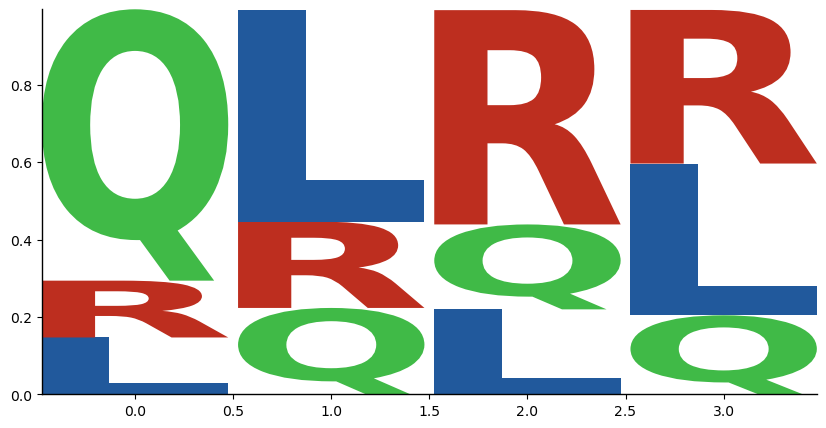

<AxesSubplot:>

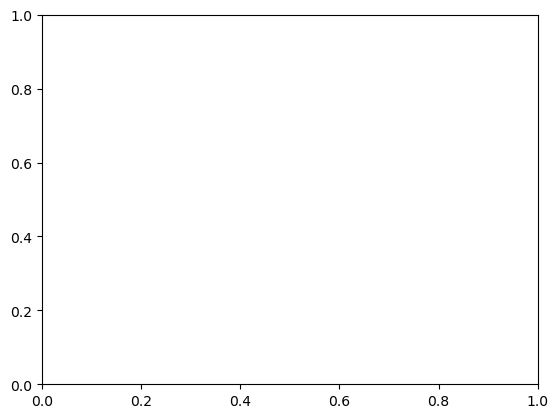

In [10]:
original = torch.tensor([[[0.0000, 1.0000, 0.0000],
         [1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 1.0000],
         [1.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333]]])

recon_psa = torch.tensor([[[0.1454, 0.7048, 0.1454],
          [0.7032, 0.1739, 0.1193],
          [0.1671, 0.1099, 0.7197],
          [0.1906, 0.1906, 0.6131]],


        [[0.1484, 0.6987, 0.1484],
          [0.3300, 0.3300, 0.3301],
          [0.5482, 0.2225, 0.2225],
          [0.5821, 0.2058, 0.2058]]])

ideal = torch.tensor([[[0.0000, 1.0000, 0.0000],
         [1.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 1.0000]],

        [[0.0000, 1.0000, 0.0000],
         [0.3333, 0.3333, 0.3333],
         [0.0000, 0.0000, 1.0000],
         [1.0000, 0.0000, 0.0000]]])

PSA = torch.tensor([[[0.1454, 0.7048, 0.1454],
         [0.7635, 0.1165, 0.1165],
         [0.1093, 0.1093, 0.7781],
         [0.2027, 0.2027, 0.5885]],

        [[0.1484, 0.6987, 0.1484],
         [0.3300, 0.3300, 0.3300],
         [0.3299, 0.3299, 0.3301],
         [0.5821, 0.2058, 0.2058]]])


plot_logos_probs(original, ['L','Q','R'], '../../Results', 'psa_align')
plot_logos_probs(recon_psa, ['L','Q','R'], '../../Results', 'psa_align')

plot_logos_probs(ideal, ['L','Q','R'], '../../Results', 'psa_align')
plot_logos_probs(PSA, ['L','Q','R'], '../../Results', 'psa_align')



In [ ]:
T.interpolation_type = 'GP'
x1_trans3, sampled_data3, forw_per = T.spatial_transformation(x1, ref_msa, -theta_est_GP, modeflag)


Alignment of samples: 100%|██████████| 500/500 [01:12<00:00,  6.89iters/s, loss=-0.5236928462982178]


reverse transformed CPAB using GP: 

 tensor([[[0.5000, 0.5000],
         [0.1562, 0.8438],
         [0.1563, 0.8437],
         [0.1558, 0.8442]]], grad_fn=<PermuteBackward>)


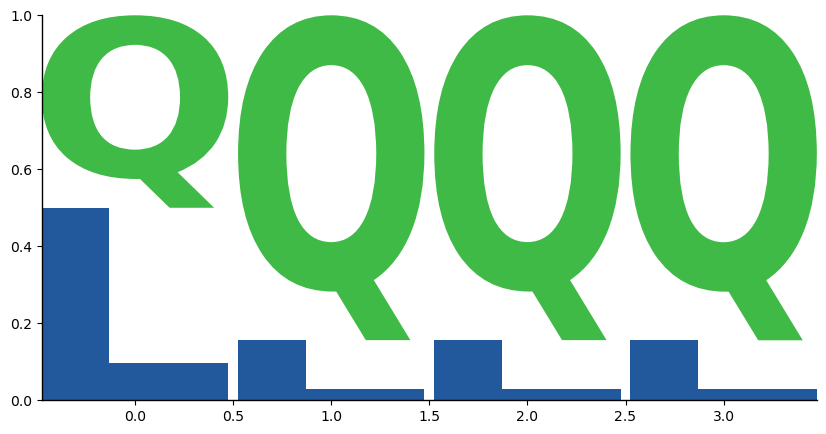

input: tensor([[[0., 1.],
         [0., 1.],
         [0., 1.],
         [1., 0.]]]) 

ref: tensor([[[1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.]]]) 

inverse transform: tensor([[[0.5000, 0.5000],
         [0.1562, 0.8438],
         [0.1563, 0.8437],
         [0.1558, 0.8442]]], grad_fn=<PermuteBackward>)


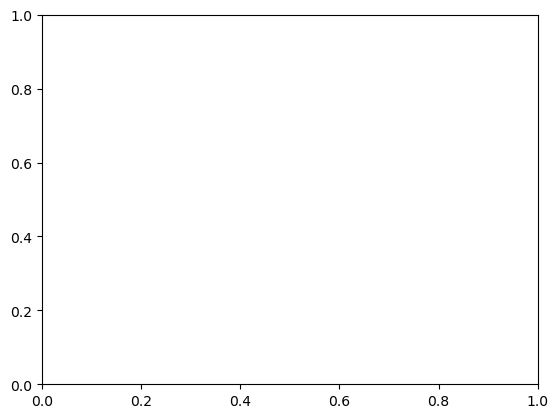

In [ ]:
T.interpolation_type = 'GP'
theta_est_GP = training_theta_optima(path_preexist_modelGP, theta_est_GP, maxiter, optimizerGP, T, x1, ref_msa, 
                                            modeflag, msa_numGP, loss_valsgp, loss_function, inverse = inverse)

x1_trans3, sampled_data3, forw_per = T.spatial_transformation(x1, ref_msa, -theta_est_GP, modeflag)
print("reverse transformed CPAB using GP: \n\n {0}".format(x1_trans3))
plot_logos_probs(x1_trans3, alphabets, '../../Results', '_4aa_nopadd_with_init')
print("input: {0} \n".format(x1))
print("ref: {0} \n".format(ref_msa))

print("inverse transform: {0}".format(x1_trans3))

findfont: Font family ['Liberation Sans Narrow'] not found. Falling back to DejaVu Sans.


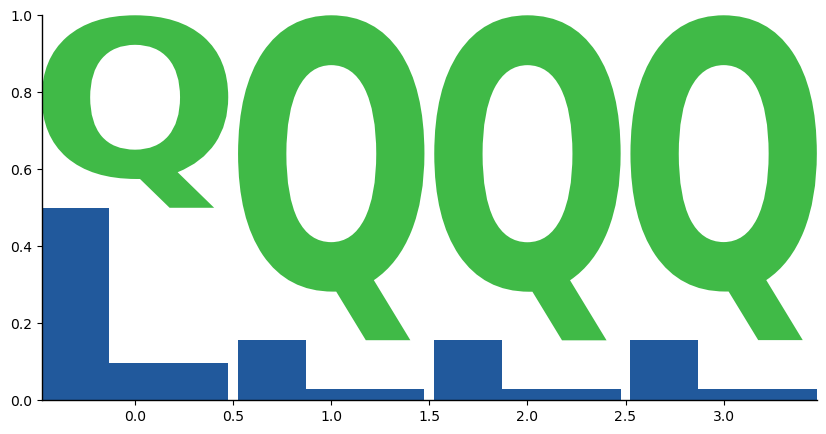

<AxesSubplot:>

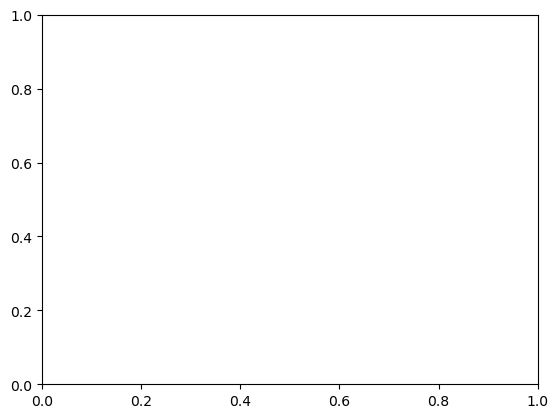